In [1]:
from pathlib import Path
from datetime import datetime as dt
import pandas as pd
import geopandas as gpd
import requests
import numpy as np
from sampling_handler.misc import py_helpers
#from sampling_handler.time_series import change_detections
from retrying import retry

import ee
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

/home/sepal-user/venv/pre_esbae/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


In [10]:
def get_segments(ccdcAst, mask_1d):
    """ """
    bands_2d = ccdcAst.select(".*_coefs").bandNames()
    bands_1d = ccdcAst.bandNames().removeAll(bands_2d)
    segment_1d = ccdcAst.select(bands_1d).arrayMask(mask_1d)
    mask_2d = mask_1d.arrayReshape(ee.Image(ee.Array([-1, 1])), 2)
    segment_2d = ccdcAst.select(bands_2d).arrayMask(mask_2d)
    return segment_1d.addBands(segment_2d).updateMask(segment_1d.select(0).arrayLength(0).gt(0))


def get_segment(ccdcAst, mask_1d):
    """ """
    bands_2d = ccdcAst.select(".*_coefs").bandNames()
    bands_1d = ccdcAst.bandNames().removeAll(bands_2d)
    segment_1d = ccdcAst.select(bands_1d).arrayMask(mask_1d).arrayGet([0])
    mask_2d = mask_1d.arrayReshape(ee.Image(ee.Array([-1, 1])), 2)
    segment_2d = ccdcAst.select(bands_2d).arrayMask(mask_2d).arrayProject([1])
    return segment_1d.addBands(segment_2d).updateMask(segment_1d.select(0).arrayLength(0).gt(0))


def transform_date(date):
    """ """
    date = pd.to_datetime(dt.fromtimestamp(date / 1000.0))
    dates_float = date.year + np.round(date.dayofyear / 365, 3)
    dates_float = 0 if dates_float == 1970.003 else dates_float
    return dates_float

In [3]:
point_id_name = 'point_id'

# start of calibration period (mainly for bfast)
start_calibration = "2018-01-01"  # YYYY-MM-DD format

# Actual period of interest, i.e. monitoring period
start_monitor =     "2021-01-01"  # YYYY-MM-DD format
end_monitor =       "2023-01-01"  # YYYY-MM-DD format

# Directory where output and temp files will go
outdir = 'results'  # goes to module_results/sbae_point_analysis if set to None

# Select algorithms to run (Treu or False)
cusum_deforest =  False
bfast_monitor =   False
bs_slope =        False
ts_metrics =      False
ccdc =            True
landtrendr =      False
jrc_nrt =         False
global_products = False

# select the bands to extract
bands = ['green', 'red', 'nir', 'swir1', 'swir2', 'ndfi'] # other choices: ndfi, ndmi, mndwi, brightness, greenness, wetness

# select the band for univariate ts-analysis (has to be inside bands list)
ts_band = 'ndfi'

# select the resolution to which the satellite data will be resized.
scale = 70  # in meters (70 m is half ha, relates to FAO forest definition)

### DO NOT CHANGE YET ###
satellite='Landsat'  # this is going to be Surface Reflactance, Collection 2, Tier 1 data only
max_cloud_cover = 75  # in percentage (0-100)

In [4]:
# landsat related parameters
lsat_params = {
    'l9':     True,
    'l8':     True,
    'l7':     True,
    'l5':     True,
    'l4':     True,
    'brdf':   True,
    'bands':  bands,
    'max_cc': max_cloud_cover
}

# bfast parameters
bfast_params = {
    'run':           bfast_monitor,
    'start_monitor': start_monitor, 
    'freq':          365,
    'k':             3, 
    'hfrac':         0.25, 
    'trend':         True, 
    'level':         0.05, 
    'backend':       'python'
}

# cusum parameters
cusum_params = {
    'run':              cusum_deforest,
    'nr_of_bootstraps': 1000
}

# slope parameters
bs_slope_params = {
    'run':              bs_slope,
    'nr_of_bootstraps': 1000
}

# time-series metrics
ts_metrics_params = {
    'run':              ts_metrics,
    'outlier_removal':  False,
    'z_threshhold':     3
}

# ccdc parameters
ccdc_params = {
    'run':                   ccdc,
    'breakpointBands':       ['green', 'red', 'nir', 'swir1', 'swir2'],
    'tmaskBands':            ['green', 'swir2'],
    'minObservations':       6,
    'chiSquareProbability':  .99,
    'minNumOfYearsScaler':   1,
    'dateFormat':            2,
    'lambda':                20,
    'maxIterations':         1000
}


landtrendr_params = { 
        'run':                    landtrendr,
        'maxSegments':            6,
        'spikeThreshold':         0.9,
        'vertexCountOvershoot':   3,
        'preventOneYearRecovery': True,
        'recoveryThreshold':      0.25,
        'pvalThreshold':          0.05,
        'bestModelProportion':    0.75,
        'minObservationsNeeded':  3
}

jrc_nrt_params = {
    'run': jrc_nrt
}

# global products parameters
global_products = {
    'run':                      global_products,
    'gfc':                      True,     # will include tree-cover 2000, loss, gain, lossyear
    'tmf':                      True,    # will include deforestation and degradation year for tropical moist forests
    'tmf_years':                True,    # will include classes per year - according to the monitor period
    'esa_lc20':                 True,    # will include ESA LandCover Product class
    'copernicus_lc':            True,    # will include ESA LandCover Product class - acording to the monitoring years
    'esri_lc':                  True,    # will include the classes from ESRI World Cover 2020
    'lang_tree_height':         True,    # returns the Tree Height from Lang et al 2022
    'potapov_tree_height':      True,    # returns the tree height from Potapov et al. 2019 
    'elevation':                True,    # returns elevation, slope and aspect
    'dynamic_world_tree_prob':  True,    # returns Min, Max, Mean and StdDev of the trees probability for the monitoring period
    'dynamic_world_class_mode': True     # returns the mode of the class for the monitoring period   
}

### DO NOT CHANGE ###
### GATHER ALL INFO INTO A DICT #####
config_dict = {
    'work_dir':                         outdir,
    'workers':                          500,
    'file_accumulation':                25000,
    'max_points_per_chunk':             250,
    'grid_size_levels':                 [4, 2, 1, 0.5, 0.25, 0.125, 0.075],  # definition of chunk sizes in degrees  
    'lsat_params':                      lsat_params,
    'ts_params': {
        'start_calibration':            start_calibration,
        'start_monitor':                start_monitor,
        'end_monitor':                  end_monitor,
        'point_id':                     point_id_name,
        'bands':                        bands,
        'ts_band':                      ts_band,
        'satellite':                    satellite,
        'scale':                        scale,
        'max_cc':                       max_cloud_cover,
        'outlier_removal':              True,
        'smooth_ts':                    True       
    },    
    'bfast_params':                     bfast_params,
    'cusum_params':                     cusum_params,
    'bs_slope_params':                  bs_slope_params,
    'ts_metrics_params':                ts_metrics_params,
    'ccdc_params':                      ccdc_params,
    'landtrendr_params':                landtrendr_params,
    'jrc_nrt_params':                   jrc_nrt_params,
    'global_products':                  global_products
}

In [5]:
ts_dir = Path('/home/sepal-user/test_esbae/results/Landsat')
#ts_dir = Path('/home/sepal-user/module_results/esbae/Belize_MRV/03_Timeseries_Extract/Landsat')
files = list(ts_dir.glob('*geojson'))

p, j, to_concat = 0, 0, []
for i, file in enumerate(files):

    gdf = py_helpers.geojson_to_gdf(file, convert_dates=True)
    p += len(gdf)
    to_concat.append(gdf)

    if p > 200:
        # accumulate files to dataframe until length is reached
        print(f'Accumulated batch {j+1} of files')
        # run change routine on accumulated files
        cdf = pd.concat(to_concat).head(1)
        break
        
display(cdf.head(5))

Accumulated batch 1 of files


,geometry,point_id,dates,ts,images
0,POINT (35.87430 10.19384),37369,"DatetimeIndex(['2013-01-05', '2013-02-06', '20...","{'green': [498, 590, 638, 842, 798, 757, 482, ...",223


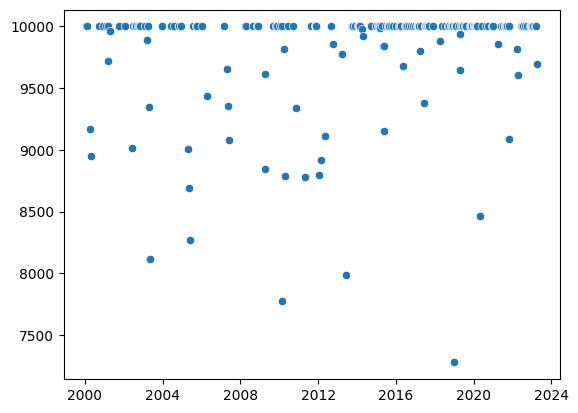

In [66]:
import seaborn as sns
def plot_timeseries(df, point_id, point_id_name="point_id"):

    
    dates = df[df[point_id_name] == point_id].dates.values[0]
    ts = np.array(df[df[point_id_name] == point_id].ts.values[0]['ndfi'])

    sns.scatterplot(x=dates, y=ts)
    
plot_timeseries(cdf.head(1), 2184)

In [12]:
%%time

#@retry(stop_max_attempt_number=3, wait_random_min=5000, wait_random_max=10000)
def run_ccdc(df, samples, config_dict):
    ccdc_params = config_dict["ccdc_params"]
    ts_band = config_dict["ts_params"]["ts_band"]
    bands = config_dict["ts_params"]["bands"]
    point_id_name = config_dict["ts_params"]["point_id"]

    start_calibration = config_dict["ts_params"]["start_calibration"]
    start_monitor = config_dict["ts_params"]["start_monitor"]
    end_monitor = config_dict["ts_params"]["end_monitor"]
    scale = config_dict["ts_params"]["scale"]
    print(ts_band, start_monitor, end_monitor)
    #args_list, iColl, points = [], None, None
    args_list, iColl, points = [], None, []
    for i, row in df.iterrows():

        # get dates
        dates = ee.List([dt.strftime(date, "%Y-%m-%d") for date in row.dates])
        #print(dates.getInfo())
        # transform ts dict into way to ingest into imagery
        ts = []
        for j in range(len(row.dates)):
            ts.append([v[j] for v in row.ts.values()])
        
        #print(ts)
        # gather points for feature collection to reduce on
        geom = ee.Feature(
            row.geometry.__geo_interface__
        ).set(point_id_name, row[point_id_name])
        squared = geom.geometry().buffer(100, 10).bounds()
        points.append(row[point_id_name])
        
        # merge dates with ts data
        ts = ee.List(ts).zip(dates)

        def zip_to_image(element):

            values = ee.List(element).get(0)
            date = ee.List(element).get(1)

            return ee.Image(
                ee.Image.constant(values)
                .rename(list(row.ts.keys()))
                .clip(squared)
                .set("system:time_start", ee.Date.parse("YYYY-MM-dd", date).millis())
                .toFloat()
            )

        # create the image collection
        tsee = ee.ImageCollection(ts.map(zip_to_image))
        iColl = iColl.cat(tsee.toList(tsee.size())) if iColl else tsee.toList(tsee.size())
    
    points = samples.filter(ee.Filter.inList(point_id_name, points))
    
    iColl = ee.ImageCollection.fromImages(iColl)
    #print(iColl.getInfo())
    # add collection and remove run from parameter dict
    ccdc_params.update(collection=iColl)
    ccdc_params.pop("run", None)
    #print(ccdc_params)
    # run ccdc
    ccdc = ee.Algorithms.TemporalSegmentation.Ccdc(**ccdc_params)
    
    # extract info
    # create array of start of monitoring in shape of tEnd
    tEnd = ccdc.select("tEnd")
    mon_date_array_start = tEnd.multiply(0).add(ee.Date(start_monitor).millis())
    mon_date_array_end = tEnd.multiply(0).add(ee.Date(end_monitor).millis())

    # create the date mask
    date_mask = tEnd.gte(mon_date_array_start).And(tEnd.lte(mon_date_array_end))
    
    # use date mask to mask all of ccdc
    monitoring_ccdc = get_segments(ccdc, date_mask)

    # mask for highest magnitude in monitoring period
    magnitude = monitoring_ccdc.select(f'{ts_band}_magnitude')
    max_abs_magnitude = (
    magnitude.abs()
        .arrayReduce(ee.Reducer.max(), [0])
        .arrayGet([0])
        .rename("max_abs_magnitude")
        )
    
    mask = magnitude.abs().eq(max_abs_magnitude)
    segment = get_segment(monitoring_ccdc, mask)
    print(segment.getInfo())
    magnitude = ee.Image(segment.select([f'{ts_band}_magnitude', "tBreak", "tEnd"]))
    
    def pixel_value_nan(feature):
        pixel_value = ee.List([feature.get(f'{ts_band}_magnitude'), -9999]).reduce(
            ee.Reducer.firstNonNull()
        )
        return feature.set({f'{ts_band}_magnitude': pixel_value})
    
    sampled_points = magnitude.reduceRegions(**{
            "reducer": ee.Reducer.first(),
            "collection": points,
            "scale": 100,
            "tileScale": 4,
        }).map(pixel_value_nan).select(
            propertySelectors=[point_id_name, f'{ts_band}_magnitude', "tBreak", "tEnd"],
            retainGeometry=False
    )
    print(sampled_points.first().propertyNames().getInfo())
    url = sampled_points.getDownloadUrl("geojson")
    
    # Handle downloading the actual pixels.
    r = requests.get(url, stream=True)
    if r.status_code != 200:
        raise r.raise_for_status()

    return pd.DataFrame([feature['properties'] for feature in r.json()['features']])

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 14.1 µs


In [13]:
%%time
samples = ee.FeatureCollection('users/andreasvollrath/eth_ts_analysis/ethiopia_hex_centroids_dggrid_15')
#samples = ee.FeatureCollection('users/andreasvollrath/Belize_MRV/centroid_samples_ISEA3H_16').select('point_id')
ccdc_args = []
for i in range(0, len(cdf), 10):
    
    ccdc_args.append([cdf.iloc[i:i+10], samples, config_dict])
    
result = py_helpers.run_in_parallel(run_ccdc, ccdc_args, workers=20)
gdf = pd.concat(result)
gdf["ccdc_change_date"] = gdf["tBreak"].apply(lambda x: transform_date(x))
gdf["ccdc_magnitude"] = gdf[f"ndfi_magnitude"]
gdf

ndfi 2021-01-01 2023-01-01
{'type': 'Image', 'bands': [{'id': 'tStart', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'tEnd', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'tBreak', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'numObs', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'changeProb', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'green_rmse', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'red_rmse', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', '

,ndfi_magnitude,point_id,tBreak,tEnd,ccdc_change_date,ccdc_magnitude
0,0.0,37369,0.0,1.671840e+12,0,0.0


In [54]:
file = '/home/sepal-user/module_results/esbae/Belize_MRV/04_Data_Augmentation/Landsat/0_change.geojson'
df = py_helpers.geojson_to_gdf(file)
df.columns

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esri_lc20', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope', 'tmf_defyear',
       'tmf_degyear', 'tmf_main', 'tmf_sub'],
      dtype='obj

In [57]:
df.cusum_change_date.max()

2023.0